In [1]:
### imports

import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import roc_curve, auc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
import seaborn as sns
import uproot
import awkward as ak
from scripts.models import MLP
from scripts.ksplot import make_ks_plot
import pickle

In [2]:
# latex settings block

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.numpoints": 1,
    "axes.linewidth": 2,
    "legend.title_fontsize": 16,
    "axes.labelsize": 18,
    "legend.fontsize": 16
})

In [3]:
# load training and testing arrays along with their labels and variable and label names
# such a file is created at the end of the explore.ipynb notebook
with np.load('root_files/train_validate_49variables.npz') as f:
    X_train = f['X_train']
    y_train = f['y_train']
    X_test = f['X_test']
    y_test = f['y_test']
    features = f['variables'].tolist()
    labels = f['labels'].tolist()

In [4]:
to_use = [
         # number of tracks and number of SVs always used
          'fj_jetNTracks',
          'fj_nSV',
         # adding full jet kinematics
          'fj_eta',
          'fj_mass',
          'fj_phi',
          'fj_pt',
         # adding kinematic variables defined for the two soft drop subjets
          'fj_ptDR',
          'fj_relptdiff',
          'fj_sdn2',
          'fj_sdsj1_eta',
          'fj_sdsj1_mass',
          'fj_sdsj1_phi',
          'fj_sdsj1_pt',
          'fj_sdsj1_ptD',
          'fj_sdsj2_eta',
          'fj_sdsj2_mass',
          'fj_sdsj2_phi',
          'fj_sdsj2_pt',
          'fj_sdsj2_ptD',
          'fj_z_ratio',
         # adding N-subjettiness variables
          'fj_tau1',
          'fj_tau2',
          'fj_tau3',
          'fj_tau21',
          'fj_tau32',
         # adding variables related to N-subjettines axes
          'fj_tau0_trackEtaRel_0',
          'fj_tau0_trackEtaRel_1',
          'fj_tau0_trackEtaRel_2',
          'fj_tau1_trackEtaRel_0',
          'fj_tau1_trackEtaRel_1',
          'fj_tau1_trackEtaRel_2',
          'fj_tau_vertexMass_0',
          'fj_tau_vertexMass_1',
          'fj_tau_vertexEnergyRatio_0',
          'fj_tau_vertexEnergyRatio_1',
          'fj_tau_flightDistance2dSig_0',
          'fj_tau_flightDistance2dSig_1',
          'fj_tau_vertexDeltaR_0',
         # adding impact parameter significance variables
          'fj_trackSipdSig_0',
          'fj_trackSipdSig_1',
          'fj_trackSipdSig_2',
          'fj_trackSipdSig_3',
          'fj_trackSipdSig_0_0',
          'fj_trackSipdSig_0_1',
          'fj_trackSipdSig_1_0',
          'fj_trackSipdSig_1_1',
          'fj_trackSip2dSigAboveCharm_0',
          'fj_trackSip2dSigAboveBottom_0',
          'fj_trackSip2dSigAboveBottom_1'
         ]

num_of_variables = len(to_use)
indices = sorted([features.index(i) for i in to_use])
X_train_final = X_train[:,indices]
X_test_final = X_test[:,indices]

titles = {6: 'Full jet kinematics',
          20: '+ Kinematics for soft drop subjets',
          25: '+ N-subjettiness',
          38: '+ N-subjettiness related variables',
          49: '+ Impact parameter significances'}

title = titles[num_of_variables]
print(title)

print(X_train_final.shape)
print(X_test_final.shape)

+ Impact parameter significances
(3022214, 49)
(989076, 49)


In [5]:
# build a simple neural network in keras with our imported MLP class
model = MLP(X_train_final.shape[1])
model.save_random_weights()
model.show_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 49)               196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 60)                3000      
                                                                 
 dense_1 (Dense)             (None, 60)                3660      
                                                                 
 dense_2 (Dense)             (None, 2)                 122       
                                                                 
Total params: 6,978
Trainable params: 6,880
Non-trainable params: 98
_________________________________________________________________
None


In [6]:
# train the model for 10 epochs for different values of learning rate and keep the value of the loss function
# for each learning rate at the end of the 10th epoch
# plot the loss vs the learning rate to find the optimal learning rate (lowest loss at epoch 10)
# keep the optimal learning rate and print it
# model.find_optimal_lr(X_train_final, y_train, np.logspace(-3,0,20), verbosity = 0)

In [7]:
%%time
# fit keras model using the calculated optimal learning rate and save the best weights in a file
history = model.train(X_train_final, y_train, X_test_final, y_test, 0.05)

Epoch 1/200


2022-12-04 22:42:50.680783: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


47/47 [==============================] - 2s 26ms/step - loss: 0.4915 - accuracy: 0.7754 - val_loss: 0.3932 - val_accuracy: 0.8292
Epoch 2/200
47/47 [==============================] - 1s 20ms/step - loss: 0.3584 - accuracy: 0.8453 - val_loss: 0.3294 - val_accuracy: 0.8598
Epoch 3/200
47/47 [==============================] - 1s 19ms/step - loss: 0.3139 - accuracy: 0.8668 - val_loss: 0.3004 - val_accuracy: 0.8731
Epoch 4/200
47/47 [==============================] - 1s 19ms/step - loss: 0.2927 - accuracy: 0.8765 - val_loss: 0.2852 - val_accuracy: 0.8798
Epoch 5/200
47/47 [==============================] - 1s 19ms/step - loss: 0.2804 - accuracy: 0.8821 - val_loss: 0.2755 - val_accuracy: 0.8842
Epoch 6/200
47/47 [==============================] - 1s 19ms/step - loss: 0.2721 - accuracy: 0.8859 - val_loss: 0.2683 - val_accuracy: 0.8876
Epoch 7/200
47/47 [==============================] - 1s 19ms/step - loss: 0.2657 - accuracy: 0.8890 - val_loss: 0.2625 - val_accuracy: 0.8903
Epoch 8/200
47/47 

47/47 [==============================] - 1s 21ms/step - loss: 0.1938 - accuracy: 0.9218 - val_loss: 0.1936 - val_accuracy: 0.9216
Epoch 59/200
47/47 [==============================] - 1s 20ms/step - loss: 0.1933 - accuracy: 0.9219 - val_loss: 0.1933 - val_accuracy: 0.9216
Epoch 60/200
47/47 [==============================] - 1s 20ms/step - loss: 0.1929 - accuracy: 0.9221 - val_loss: 0.1928 - val_accuracy: 0.9219
Epoch 61/200
47/47 [==============================] - 1s 20ms/step - loss: 0.1925 - accuracy: 0.9223 - val_loss: 0.1924 - val_accuracy: 0.9222
Epoch 62/200
47/47 [==============================] - 1s 19ms/step - loss: 0.1921 - accuracy: 0.9225 - val_loss: 0.1920 - val_accuracy: 0.9224
Epoch 63/200
47/47 [==============================] - 1s 20ms/step - loss: 0.1917 - accuracy: 0.9227 - val_loss: 0.1916 - val_accuracy: 0.9225
Epoch 64/200
47/47 [==============================] - 1s 20ms/step - loss: 0.1913 - accuracy: 0.9229 - val_loss: 0.1913 - val_accuracy: 0.9226
Epoch 65/200

47/47 [==============================] - 1s 21ms/step - loss: 0.1780 - accuracy: 0.9286 - val_loss: 0.1782 - val_accuracy: 0.9285
Epoch 116/200
47/47 [==============================] - 1s 20ms/step - loss: 0.1779 - accuracy: 0.9287 - val_loss: 0.1781 - val_accuracy: 0.9285
Epoch 117/200
47/47 [==============================] - 1s 20ms/step - loss: 0.1777 - accuracy: 0.9288 - val_loss: 0.1778 - val_accuracy: 0.9287
Epoch 118/200
47/47 [==============================] - 1s 20ms/step - loss: 0.1775 - accuracy: 0.9289 - val_loss: 0.1777 - val_accuracy: 0.9288
Epoch 119/200
47/47 [==============================] - 1s 21ms/step - loss: 0.1774 - accuracy: 0.9290 - val_loss: 0.1775 - val_accuracy: 0.9288
Epoch 120/200
47/47 [==============================] - 1s 20ms/step - loss: 0.1772 - accuracy: 0.9290 - val_loss: 0.1774 - val_accuracy: 0.9289
Epoch 121/200
47/47 [==============================] - 1s 21ms/step - loss: 0.1770 - accuracy: 0.9291 - val_loss: 0.1772 - val_accuracy: 0.9290
Epoch 

Epoch 172/200
47/47 [==============================] - 1s 21ms/step - loss: 0.1711 - accuracy: 0.9317 - val_loss: 0.1714 - val_accuracy: 0.9315
Epoch 173/200
47/47 [==============================] - 1s 20ms/step - loss: 0.1710 - accuracy: 0.9317 - val_loss: 0.1713 - val_accuracy: 0.9316
Epoch 174/200
47/47 [==============================] - 1s 20ms/step - loss: 0.1710 - accuracy: 0.9318 - val_loss: 0.1712 - val_accuracy: 0.9316
Epoch 175/200
47/47 [==============================] - 1s 20ms/step - loss: 0.1708 - accuracy: 0.9318 - val_loss: 0.1712 - val_accuracy: 0.9316
Epoch 176/200
47/47 [==============================] - 1s 20ms/step - loss: 0.1707 - accuracy: 0.9319 - val_loss: 0.1712 - val_accuracy: 0.9315
Epoch 177/200
47/47 [==============================] - 1s 20ms/step - loss: 0.1707 - accuracy: 0.9319 - val_loss: 0.1710 - val_accuracy: 0.9317
Epoch 178/200
47/47 [==============================] - 1s 20ms/step - loss: 0.1706 - accuracy: 0.9319 - val_loss: 0.1709 - val_accuracy:

In [8]:
graphs = history.history

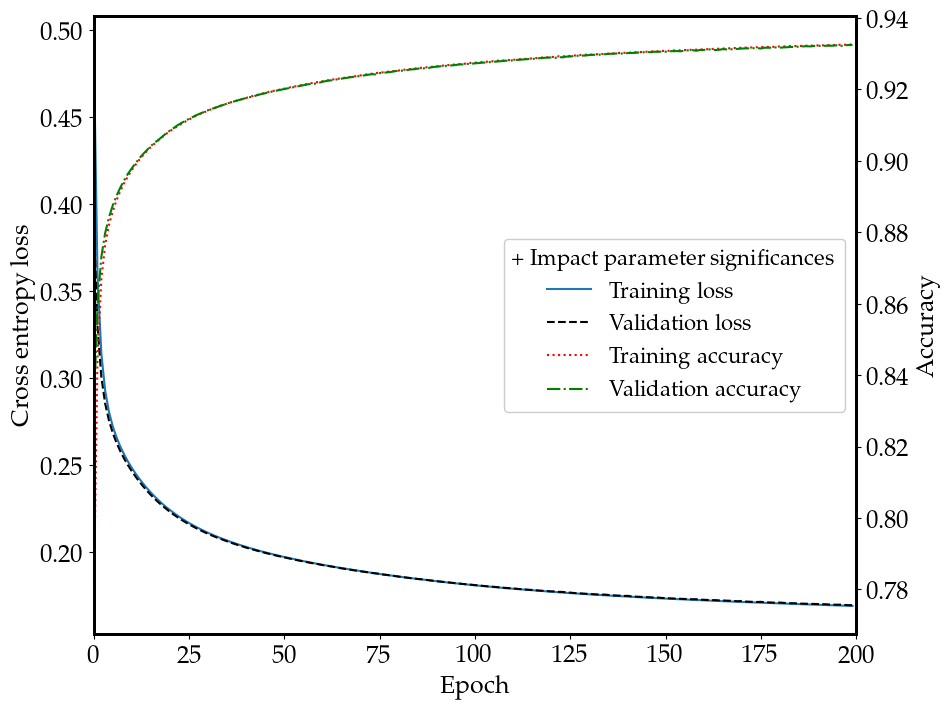

In [9]:
fig, ax1 = plt.subplots(figsize=([6.4*1.5, 4.8*1.5]))
ax1.plot(graphs['loss'], label='Training loss')
ax1.plot(graphs['val_loss'], label='Validation loss', ls = '--', color = 'k')

ax2 = ax1.twinx()
ax2.plot(graphs['accuracy'], label='Training accuracy', ls = ':', color = 'r')
ax2.plot(graphs['val_accuracy'], label='Validation accuracy', ls = '-.', color = 'g')

ax1.set_xlabel('Epoch')
ax1.set_xlim(0,200)
ax1.set_ylabel("Cross entropy loss")
ax2.set_ylabel("Accuracy")

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

handles = handles1 + handles2
labels = labels1 + labels2

fig.legend(handles,labels,title=title,framealpha=1,
          loc='center right',frameon=True,bbox_to_anchor=(1,0.5),bbox_transform=ax1.transAxes)

plt.tight_layout()
plt.savefig(f"plots/training_results_{num_of_variables}variables.pdf")
plt.show()

In [10]:
# print the loss and accuracy of the model on the train and test data sets
# run model inference on train and test data sets
evaluation_train, evaluation_test = model.evaluate(X_train_final, y_train, X_test_final, y_test, batch_size=2**16)
predict_array_train, predict_array_test = model.predict(X_train_final, X_test_final, batch_size=2**16)
accuracy = evaluation_test[1]

16/16 [==============================] - 0s 7ms/step - loss: 0.1693 - accuracy: 0.9324
[0.1688067466020584, 0.93265700340271]
[0.16931575536727905, 0.932435929775238]
16/16 [==============================] - 0s 5ms/step


In [11]:
# save the model
model.keras_model.save(f"model_checkpoints/MLP_{num_of_variables}variables.h5")

In [12]:
# create ROC curve
fpr, tpr, threshold = roc_curve(y_test[:,0], predict_array_test[:,0])
np.savez(f'plots/ROC_MLP_{num_of_variables}variables', fpr = fpr, tpr = tpr)

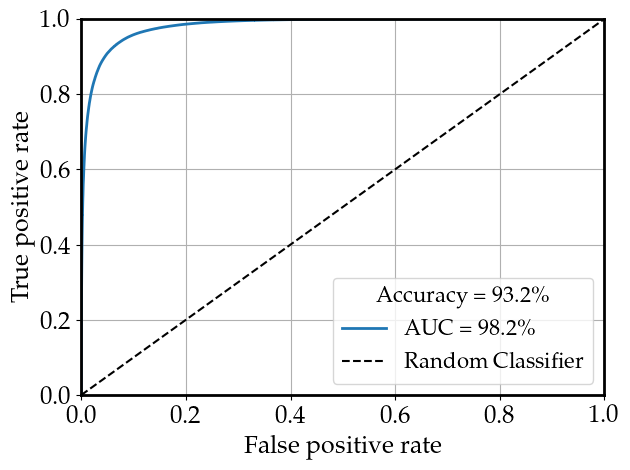

In [13]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right', title=f'Accuracy = {accuracy*100:.1f}\%')
plt.tight_layout()
plt.savefig(f'plots/ROC_MLP_{num_of_variables}variables.pdf')
plt.show()

In [14]:
# create KS histogram of classifier output to check for overtraining
fig = make_ks_plot(y_train[:,0], predict_array_train[:,0],
                   y_test[:,0], predict_array_test[:,0])
fig.savefig(f'plots/KS_MLP_{num_of_variables}variables.pdf')

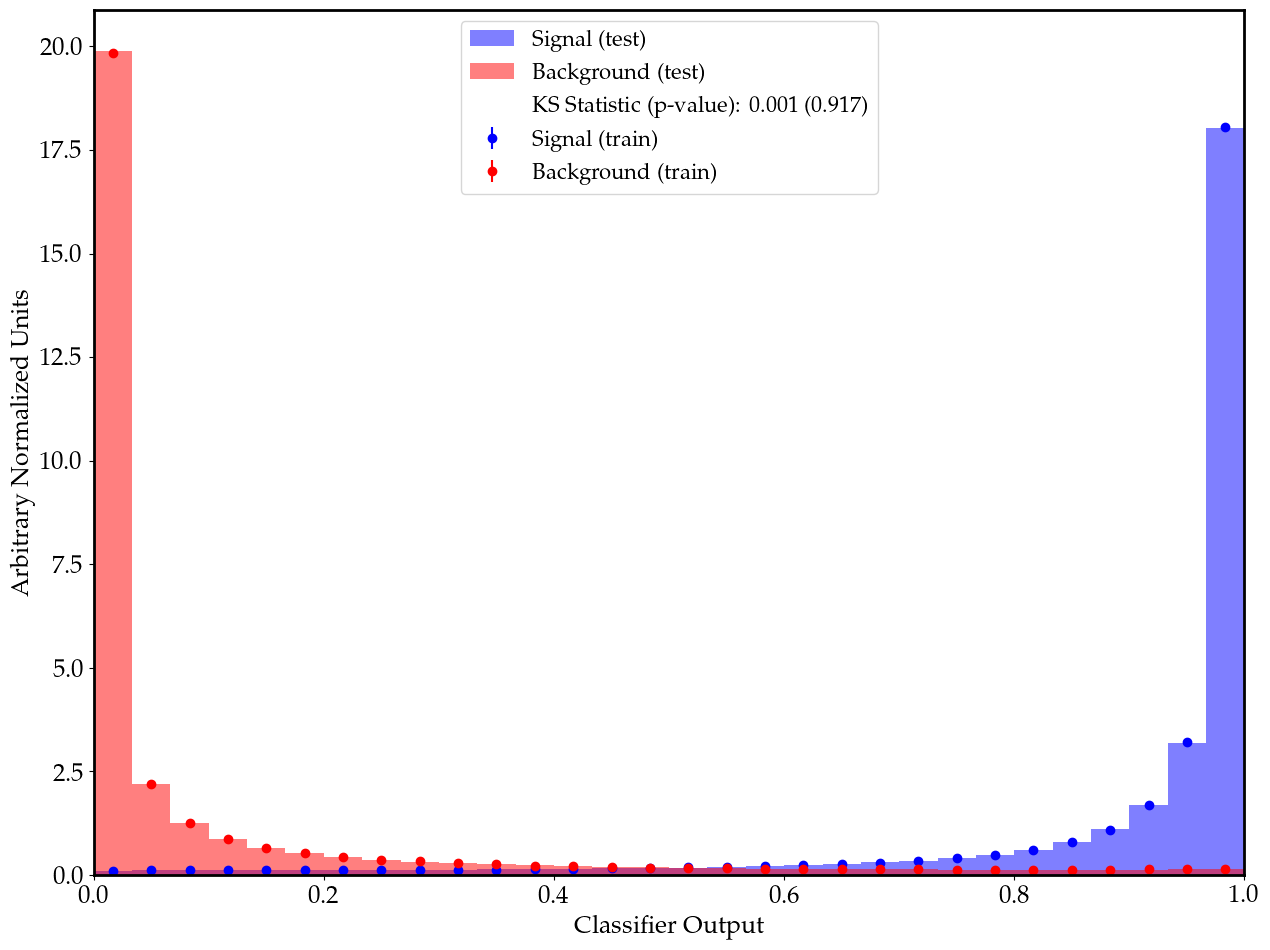

In [15]:
fig

In [16]:
# create a boosted decision tree classifier using the xgboost package
bdt = XGBClassifier(booster='gbtree')

In [17]:
%%time
# fit the BDT on training set
bdt.fit(X_train_final, y_train)

CPU times: user 1h 13min 40s, sys: 13.6 s, total: 1h 13min 53s
Wall time: 8min 47s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [18]:
# print the accuracies of the BDT on the training and testing data sets
print(bdt.score(X_train_final, y_train))
accuracy = bdt.score(X_test_final, y_test)
print(accuracy)

0.9456438227074588
0.9431368266948141


In [19]:
# save the model
bdt.save_model(f"model_checkpoints/BDT_{num_of_variables}variables.json")

In [20]:
# run BDT inference on train and test data sets and create ROC curve
predict_array_train = bdt.predict_proba(X_train_final)
predict_array_test = bdt.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test[:,0], predict_array_test[:,0])
np.savez(f'plots/ROC_BDT_{num_of_variables}variables', fpr = fpr, tpr = tpr)

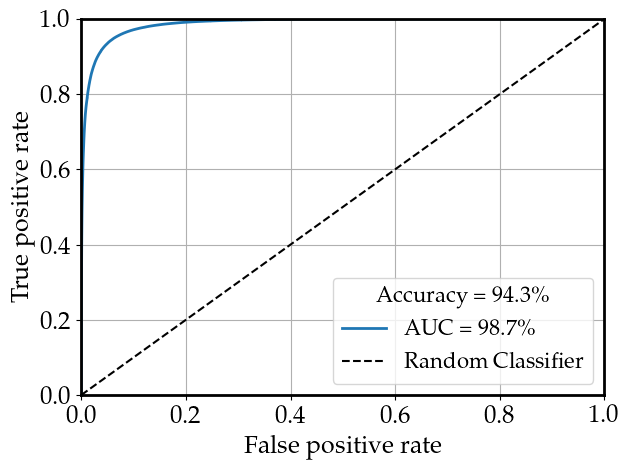

In [21]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right', title=f'Accuracy = {accuracy*100:.1f}\%')
plt.tight_layout()
plt.savefig(f'plots/ROC_BDT_{num_of_variables}variables.pdf')
plt.show()

In [22]:
# create KS histogram of classifier output to check for overtraining
fig = make_ks_plot(y_train[:,0], predict_array_train[:,0],
                   y_test[:,0], predict_array_test[:,0])
fig.savefig(f'plots/KS_BDT_{num_of_variables}variables.pdf')

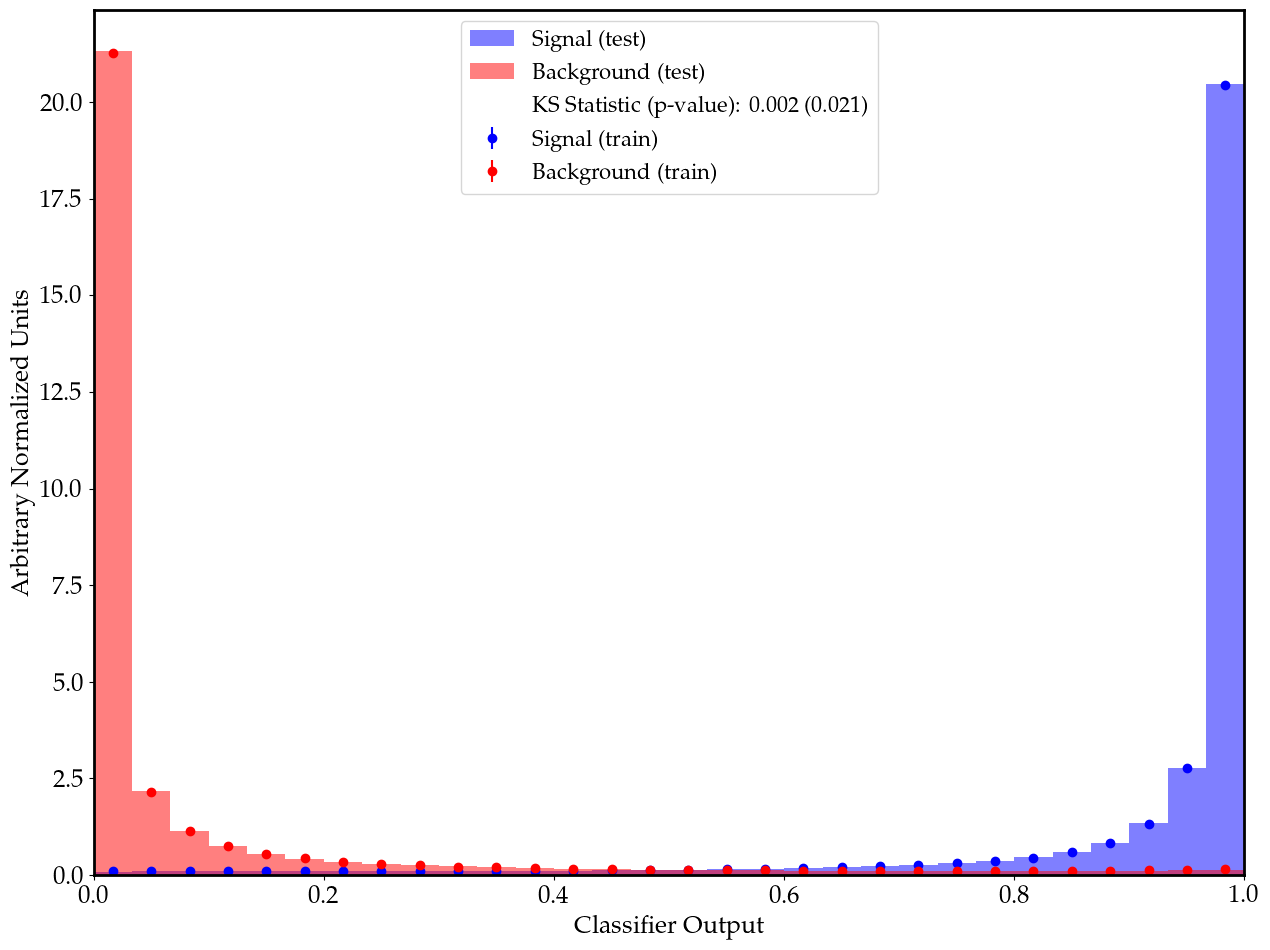

In [23]:
fig

In [24]:
# create Linear Discriminant Analysis classifier
fisher = LinearDiscriminantAnalysis()

In [25]:
%%time
# fit the LDA classifier on training set
fisher.fit(X_train_final, y_train[:,0])

CPU times: user 19.2 s, sys: 2.66 s, total: 21.9 s
Wall time: 12.2 s


LinearDiscriminantAnalysis()

In [26]:
# print the accuracies of the LDA classifier on the training and testing data sets
print(fisher.score(X_train_final, y_train[:,0]))
accuracy = fisher.score(X_test_final, y_test[:,0])
print(accuracy)

0.8584683281858928
0.8584608260639223


In [27]:
# save the model
with open(f"model_checkpoints/LDA_{num_of_variables}variables.pkl",'wb') as f:
    pickle.dump(fisher,f)

In [28]:
# run LDA classifier inference on train and test data sets and create ROC curve
predict_array_train = fisher.predict_proba(X_train_final)
predict_array_test = fisher.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test[:,0], predict_array_test[:,1])
np.savez(f'plots/ROC_LDA_{num_of_variables}variables', fpr = fpr, tpr = tpr)

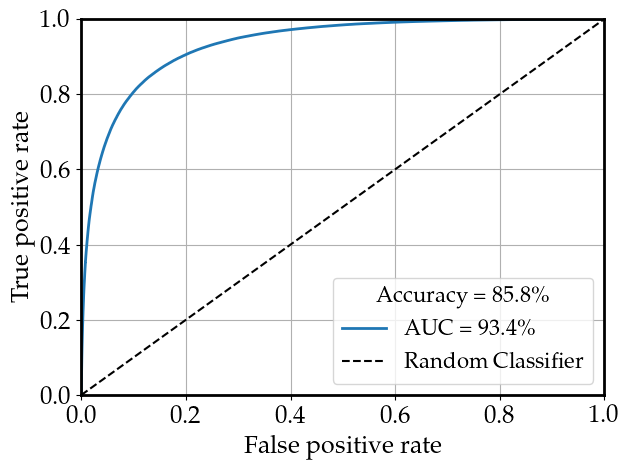

In [29]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right', title=f'Accuracy = {accuracy*100:.1f}\%')
plt.tight_layout()
plt.savefig(f'plots/ROC_LDA_{num_of_variables}variables.pdf')
plt.show()

In [30]:
# create KS histogram of classifier output to check for overtraining
fig = make_ks_plot(y_train[:,0], predict_array_train[:,1],
                   y_test[:,0], predict_array_test[:,1])
fig.savefig(f'plots/KS_LDA_{num_of_variables}variables.pdf')

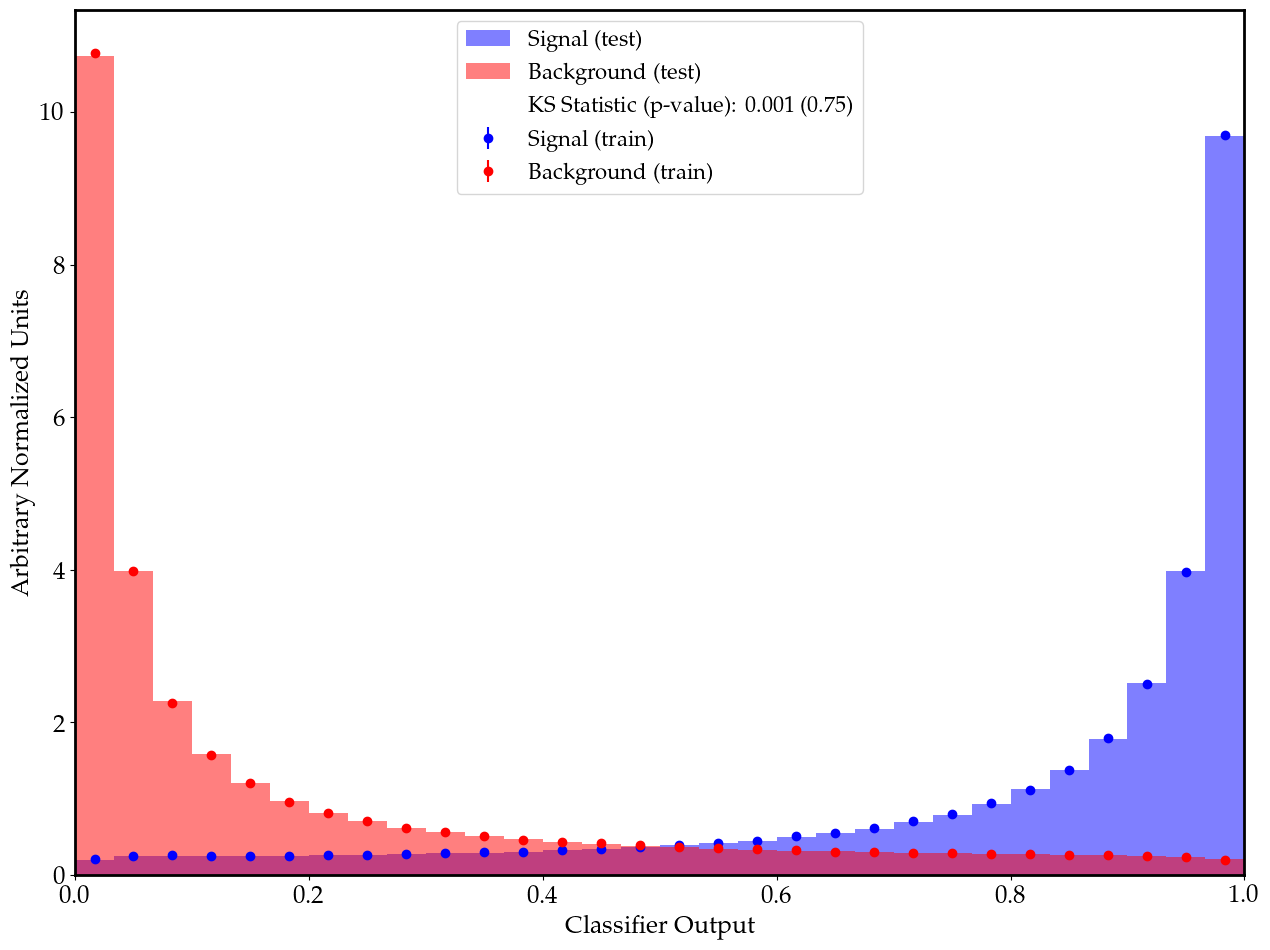

In [31]:
fig